# Moroccan Stock Market Index Prediction Using LSMT

MASI or Moroccan all share index is a major stock market index which tracks the performance of all companies listed on the Casablanca Stock Exchange.
in This project we're going to predict the future value of MASI using Recurent Neural network LSTM

##  1- Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM,Dropout
from tensorflow.keras.models import Sequential

## 2- Data import

In [2]:
masi  = pd.read_csv('data\MASI.csv')

In [3]:
masi.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,09/16/2022,"12,198.68","12,138.03","12,198.68","12,138.03",NaN,0.50%
1,09/15/2022,"12,138.03","12,145.54","12,185.49","12,130.65",NaN,-0.07%
2,09/14/2022,"12,146.06","12,138.23","12,161.07","12,129.14",NaN,-0.01%
3,09/13/2022,"12,147.77","12,132.17","12,163.10","12,130.06",NaN,0.12%
4,09/12/2022,"12,132.92","12,128.37","12,159.67","12,108.72",NaN,0.04%


In [4]:
masi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1664 entries, 0 to 1663
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1664 non-null   object 
 1   Price     1664 non-null   object 
 2   Open      1664 non-null   object 
 3   High      1664 non-null   object 
 4   Low       1664 non-null   object 
 5   Vol.      0 non-null      float64
 6   Change %  1664 non-null   object 
dtypes: float64(1), object(6)
memory usage: 91.1+ KB


## 3- Data Cleansing

* We Noticed that That the date is an object so we'll transforme it to datetime and we'll set it as the index

In [5]:
masi['Date'] = pd.to_datetime(masi['Date'] , format= '%m/%d/%Y')
masi = masi.sort_values(by = 'Date').reset_index(drop= True)
masi = masi.set_index(['Date'])

* Then we need to filter the data as we only need the Price column

In [6]:
masi = masi.iloc[:, [0,1]]

* The values in Price seems to be splitted by a comma so we'll remove it and then, transforme the Price variable into float64

In [7]:
masi['Price'] = masi['Price'].replace(',', "", regex = True)
masi['Price'] = masi['Price'].astype('float64')
masi.head()

,Price,Open
Date,,
2016-01-18,8868.67,"8,875.06"
2016-01-19,8887.85,"8,866.74"
2016-01-20,8877.99,"8,877.39"
2016-01-21,8862.43,"8,863.02"
2016-01-22,8868.44,"8,859.53"


## 4- Visualisation

###  MASI Price visualisation

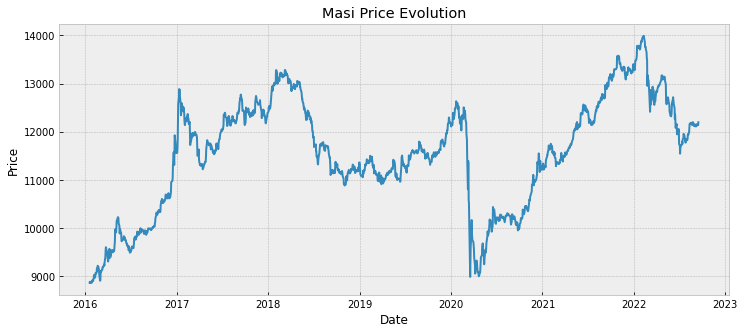

In [8]:
plt.figure(figsize =  (12,5))
sns.lineplot(data = masi, x = 'Date', y = 'Price')
plt.title('Masi Price Evolution')
##plt.xticks(rotation=45)
plt.show()

### Daily Return

* First, we'll create a daily return column and then visualise it

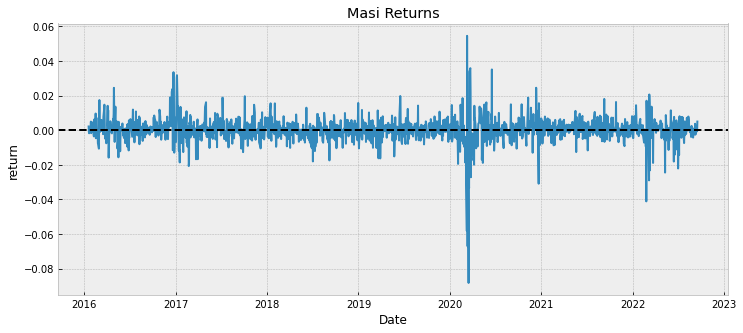

In [9]:
masi['return'] =  masi['Price'].pct_change()
plt.figure(figsize = (12,5))
sns.lineplot(data = masi, y = 'return', x = 'Date')
plt.axhline(y = 0, color = 'black', linestyle = '--' )
plt.title('Masi Returns')
plt.show()

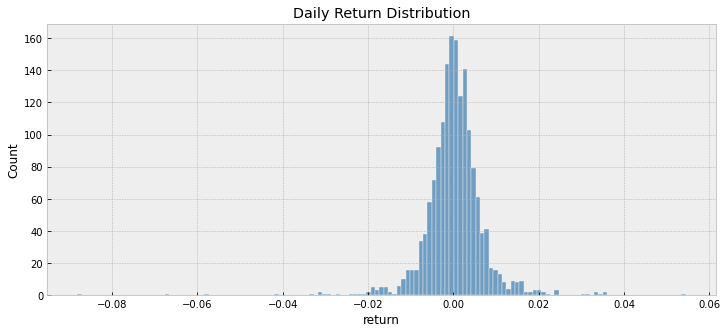

In [10]:
plt.figure(figsize = (12,5))
sns.histplot(data = masi, x = 'return', color = 'steelblue')
plt.title('Returns Distribution')
plt.title('Daily Return Distribution' )
plt.show()

### Average Daily Return in every year

In [11]:
yearly = masi.groupby(masi.index.year).mean()
yearly= yearly[['return']]

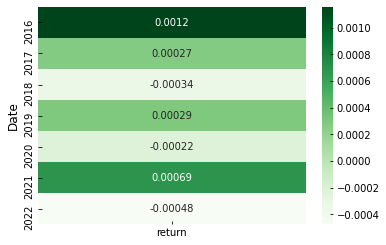

In [12]:
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
sns.heatmap(yearly, annot = True, cmap = 'Greens')
plt.show()

### Average Daily Return in every month

In [13]:
monthly = masi.groupby([masi.index.month]).mean()
monthly = monthly[['return']]

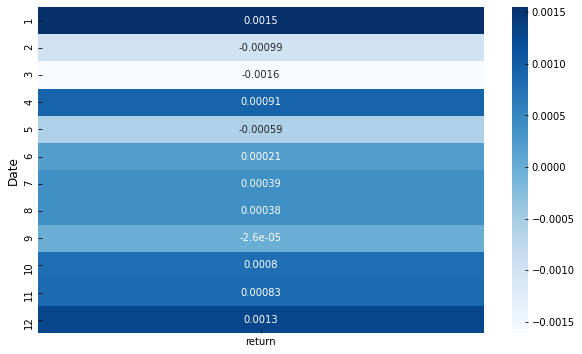

In [14]:
plt.figure(figsize = (10,6))
sns.heatmap(monthly, annot = True, cmap = 'Blues')
plt.show()

### Moving Averages

In [15]:
ma = [10,30,60]
cl = ['Moving Average 10days','Moving Average 30days','Moving Average 60days']
for i,j in zip(ma,cl):
    masi[j] = masi['Price'].rolling(i).mean()
    

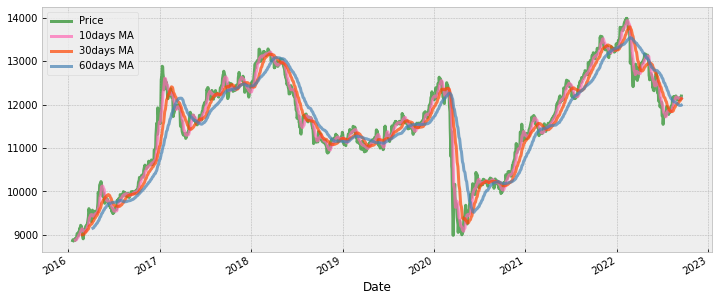

In [16]:
masi[['Price','Moving Average 10days','Moving Average 30days','Moving Average 60days']].plot(
    alpha=.7, lw=3, color = {'forestgreen','steelblue','orangered','hotpink'},figsize = (12,5))
plt.legend(['Price','10days MA', '30days MA', '60days MA'])
plt.show()

## 5- Data Preprocessing

In [17]:
#Filtering Date as we need only Price
Masi_data = masi[['Price']]

In [18]:
# Normalisation
masi_final = Masi_data.values
scaler = MinMaxScaler(feature_range = (0,1))
masi_scaled = scaler.fit_transform(masi_final)

* Data spliting and creating X_train and Y_train. 
* we choose a 60days window for our model. This means, that our model will use the last 60days to predict one day ahead

In [19]:
# Data splitting
masi_train = masi_scaled[:1330,:]
masi_test = masi_scaled[len(masi_train)-60:,:]
# creating X_train and Y_train
X_train, Y_train = [],[]
for i in range(60,len(masi_train)):
    X_train.append(masi_scaled[i-60:i,0])
    Y_train.append(masi_scaled[i,0])

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, newshape = (X_train.shape[0], X_train.shape[1], 1))

## 6- Modeling

* we choose to use LSTM model with 3 Hidden Layers

In [20]:
lstm = Sequential()
lstm.add(LSTM(128,return_sequences = True, input_shape = (X_train.shape[1],1) ))
lstm.add(Dropout(0.2))
lstm.add(LSTM(64, return_sequences = True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(64, return_sequences = False))
lstm.add(Dropout(0.2))
lstm.add(Dense(1))
lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [21]:
hs = lstm.fit(X_train,Y_train, batch_size = 32, epochs = 120)

Epoch 1/120
40/40 [==============================] - 12s 75ms/step - loss: 0.0282
Epoch 2/120
40/40 [==============================] - 3s 72ms/step - loss: 0.0060
Epoch 3/120
40/40 [==============================] - 3s 71ms/step - loss: 0.0049
Epoch 4/120
40/40 [==============================] - 3s 72ms/step - loss: 0.0042
Epoch 5/120
40/40 [==============================] - 3s 72ms/step - loss: 0.0059
Epoch 6/120
40/40 [==============================] - 3s 83ms/step - loss: 0.0045
Epoch 7/120
40/40 [==============================] - 4s 91ms/step - loss: 0.0037
Epoch 8/120
40/40 [==============================] - 4s 90ms/step - loss: 0.0037
Epoch 9/120
40/40 [==============================] - 4s 97ms/step - loss: 0.0032
Epoch 10/120
40/40 [==============================] - 4s 93ms/step - loss: 0.0030
Epoch 11/120
40/40 [==============================] - 4s 90ms/step - loss: 0.0033
Epoch 12/120
40/40 [==============================] - 4s 90ms/step - loss: 0.0030
Epoch 13/120
40/40 [====

40/40 [==============================] - 4s 89ms/step - loss: 8.8945e-04
Epoch 100/120
40/40 [==============================] - 4s 88ms/step - loss: 7.1705e-04
Epoch 101/120
40/40 [==============================] - 4s 89ms/step - loss: 7.6056e-04
Epoch 102/120
40/40 [==============================] - 4s 89ms/step - loss: 7.5094e-04
Epoch 103/120
40/40 [==============================] - 4s 89ms/step - loss: 7.4173e-04
Epoch 104/120
40/40 [==============================] - 4s 89ms/step - loss: 7.9287e-04
Epoch 105/120
40/40 [==============================] - 4s 88ms/step - loss: 8.6645e-04
Epoch 106/120
40/40 [==============================] - 4s 88ms/step - loss: 7.1617e-04
Epoch 107/120
40/40 [==============================] - 4s 89ms/step - loss: 7.3222e-04
Epoch 108/120
40/40 [==============================] - 4s 89ms/step - loss: 7.6806e-04
Epoch 109/120
40/40 [==============================] - 4s 88ms/step - loss: 6.9753e-04
Epoch 110/120
40/40 [==============================] - 4s

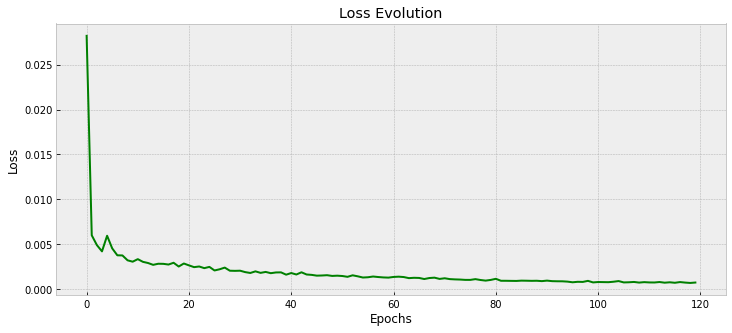

In [22]:
plt.figure(figsize = (12,5))
loss = hs.history['loss']
plt.plot(loss, 'green')
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## 7- Prediction

* First well create our X_test and then predict by using it

In [23]:
X_test = []
for i in range(60, len(masi_test)):
    X_test.append(masi_test[i-60:i,0])
X_test= np.array(X_test)
X_test = np.reshape(X_test, newshape =(X_test.shape[0], X_test.shape[1],1) )

* Prediction and inversing normalisation

In [24]:
prediction = lstm.predict(X_test)
prediction = scaler.inverse_transform(prediction)

11/11 [==============================] - 2s 38ms/step


## 8- Prediction Visualisation

<ipython-input-25-5024d4407a5c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Valid['predict'] = prediction.copy()


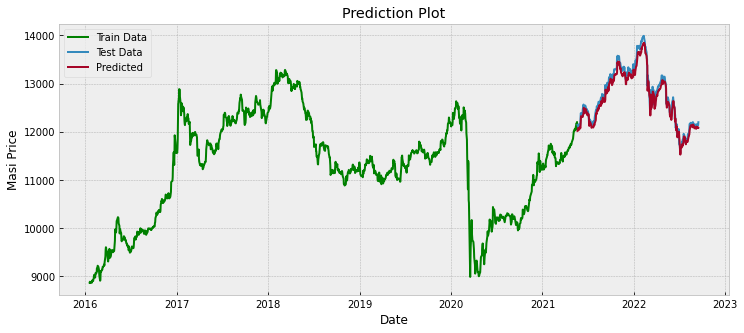

In [25]:
plt.figure(figsize = (12,5))
train = Masi_data[:len(masi_train)]
Valid = Masi_data[len(masi_train):]
Valid['predict'] = prediction.copy()
plt.plot(train, 'green')
plt.plot(Valid[['Price','predict']])
plt.xlabel('Date')
plt.ylabel('Masi Price')
plt.title('Prediction Plot')
plt.legend(['Train Data','Test Data','Predicted'])
plt.show()

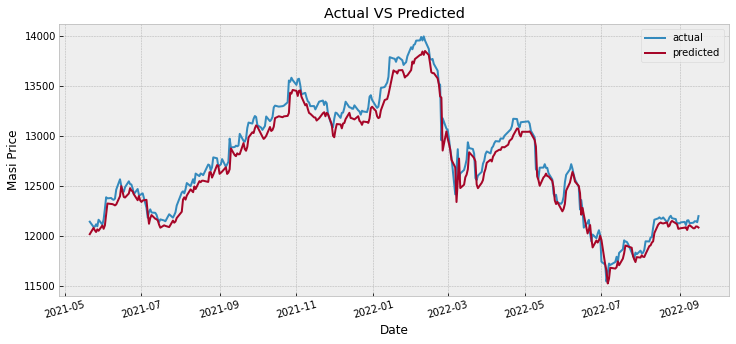

In [26]:
plt.figure(figsize = (12,5))
plt.plot(Valid)
plt.xticks(rotation = 15)
plt.xlabel('Date')
plt.ylabel('Masi Price')
plt.title('Actual VS Predicted')
plt.legend(['actual','predicted'])
plt.show()